In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import math
from numpy import dot, multiply, diag, power
from numpy.linalg import inv, eig, pinv
from scipy.linalg import svd, svdvals
from warnings import warn
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.interpolate import griddata

# Dictionary function using RBF

### Returns the centers from the data

In [2]:
def centers(data, clusters):
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(data)
    return kmeans.cluster_centers_

### Returns the Phi matrices
- Calculate the eclidean distances of data from the centers
- Use eclidean distance to calculate the phi matrix

In [3]:
def TPS(r):
    return np.power(r, 2)*np.log(r+10e-4)

def phiMat(X, clusters=100):
    data = X.T
    c = centers(data, clusters)
    eudist = euclidean_distances(data, c)
    phi =  TPS(eudist)
    return phi.T

## Calculate the K using the Phi
- K = pinv(G)*A

In [4]:
def KMat(X,Y, clus=100):
    phix = phiMat(X, clus)
    phiy = phiMat(Y,clus)
    N = X.shape[1]
    G = (1/N)*phix.T@phix
    A = (1/N)*phix.T@phiy
    K = np.linalg.pinv(G)@A
    return K, phix, phiy

### Simple DMD algorithm and eigen decomposition function

In [5]:
def dmd(X, Y, truncate=None):
    U2,Sig2,Vh2 = svd(X, False) # SVD of input matrix
    r = len(Sig2) if truncate is None else truncate # rank truncation
    U = U2[:,:r]
    Sig = diag(Sig2)[:r,:r]
    V = Vh2.conj().T[:,:r]
    Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig)) # build A tilde
    mu,W = eig(Atil)
    Phi = dot(dot(dot(Y, V), inv(Sig)), W) # build DMD modes
    return mu, Phi

def eig_decomp(Kval):
    """ Eigen-decomp of a matrix Kval """
    eigenvalues, eigenvectors = np.linalg.eig(Kval) 
    idx = eigenvalues.real.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenvectors_inv = np.linalg.inv(eigenvectors)
    return eigenvalues, eigenvectors, eigenvectors_inv


## Example 1: Simple LTI function data generation

In [6]:
def simple_LTI():
    x0 = np.random.uniform(-5,5,100)
    y0 = np.random.uniform(-5,5,100)
    X = np.array(list(map(list, zip(x0,y0))))
    J = np.array([[0.9, -0.1],[0.0, 0.8]])
    #Y = np.zeros([2, 0])
    Y = []
    for i in X:
        tempy = J@i
        Y.append(tempy)
        #Y = np.concatenate([Y, tempy], axis=1)
    X=X.T
    return X, np.asarray(Y).T

### Analytical method to calculate the eigen function and eigen value

In [7]:
def analytical_f(X,Y,i,j):
    return(((X - Y)/(2**(1/2)))**i) * (Y**j)

def analytical_v(i,j):
    return ((0.9)**i)*((0.8)**j)

## Example 2: Duffing function data generation 

In [8]:
def solve_duffing(tspan, t_data, x0=[], delta=0.5, beta=-1, alpha=1):    
    def duffing_deriv(t0, x_y, delta=delta, beta=beta, alpha=alpha):
        """Compute the time-derivative of a Duffing system."""
        x, y = x_y
        return [y, -delta*y - x*beta - alpha*(x**3)]

    # Solve for the trajectories
    x_t = np.asarray([solve_ivp(fun=duffing_deriv, t_span=t_data, y0=val, t_eval=tspan) for val in x0])
    #data = np.array([x_t[0].y[0, :], x_t[0].y[1, :]])
    return x_t

def generate_data():
    # generate data
    dt = 0.25
    max_time = 2.75
    tspan = np.arange(0, max_time, dt)
    t_data = [0, max_time]
    x0 = np.random.uniform(-2,2,1000)
    y0 = np.random.uniform(-2,2,1000)
    x_data = list(map(list, zip(x0,y0)))
    D = solve_duffing(tspan, t_data, x_data)
    X = np.zeros([2, 0])
    Y = np.zeros([2, 0])
    for i in range(1000):
        tempx = np.array([D[i].y[0, :-1], D[i].y[1, :-1]])
        tempy = np.array([D[i].y[0, 1:], D[i].y[1, 1:]])
        X = np.concatenate([X, tempx], axis=1)
        Y = np.concatenate([Y, tempy], axis=1)
    return X, Y, D

## LTI procedure

#### Generate the data

In [9]:
X,Y= simple_LTI()

#### Calculate the K matrix and decompose the K to get eigen representation

In [10]:
K,px,py = KMat(X,Y,10)
eva, evec, iev = eig_decomp(K)

### Plotting the results

#### Real part VS imag part of the eigenvalue

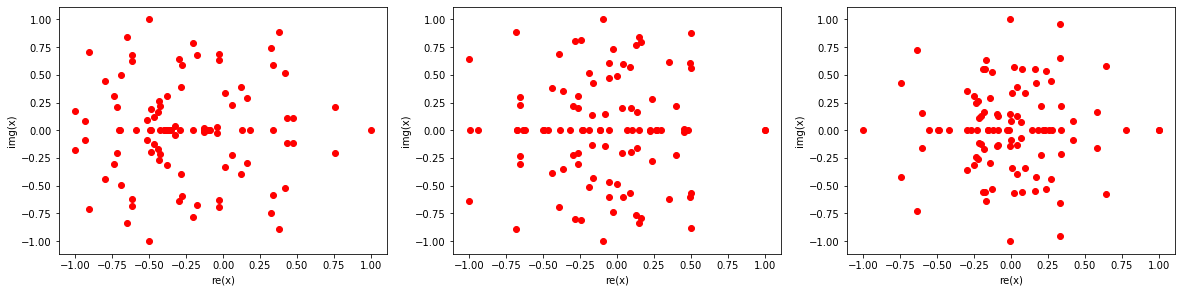

In [29]:
Xmat, Ymat = np.meshgrid(X[0], X[1])

plt.figure(figsize=(20,10))

for i in range(1, 4):
    plt.subplot(2, 3, i)
    data = evec[i]
    Xx = np.asarray([x.real for x in data])
    Xx = np.interp(Xx, (Xx.min(), Xx.max()), (-1, +1))
    Yx = np.asarray([x.imag for x in data])
    Yx = np.interp(Yx, (Yx.min(), Yx.max()), (-1, +1))
    plt.xlabel('re(x)')
    plt.ylabel('img(x)')
    plt.scatter(Xx,Yx, color='red')
    #plt.show()
    plt.savefig("real_img.png", format="png")

#### from analytical expression

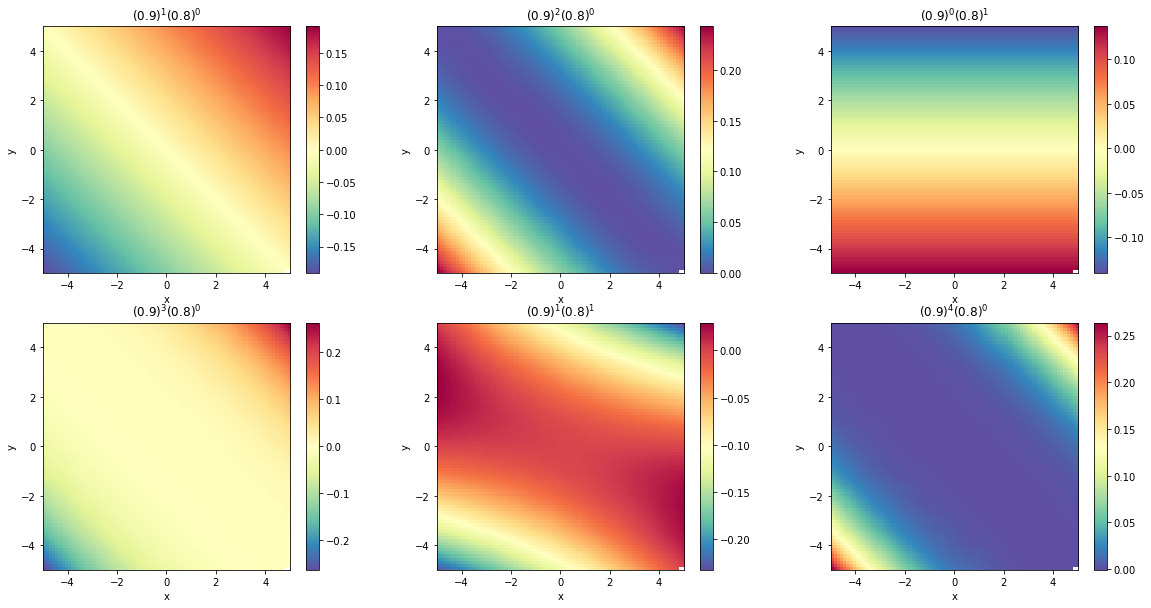

In [30]:
x = X[0]
y = X[1]

xi = np.arange(-4.0, 4.0, 0.1)
yi = np.arange(-4.0, 4.0, 0.1)
xmg, ymg = np.meshgrid(xi, yi)

lst=[(1,0), (2,0),(0,1),(3,0),(1,1),(4,0)]
plt.figure(figsize=(20,10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    a = lst[i-1][0]
    b = lst[i-1][1]
    title = r"$(0.9)^{0}(0.8)^{1}$".format(a,b)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    Za = analytical_f(X[0], X[1], a, b) 
    Za /= np.linalg.norm(Za)
    zi = griddata((x, y), Za, (xmg, ymg), method='cubic')
    im = plt.imshow(zi, cmap=plt.cm.Spectral_r, extent=(-5, 5, -5, 5))#, interpolation='bilinear')  
    plt.colorbar(im)
    plt.savefig("real_plot.png", format="png")

#### from the obtained eigenvectors

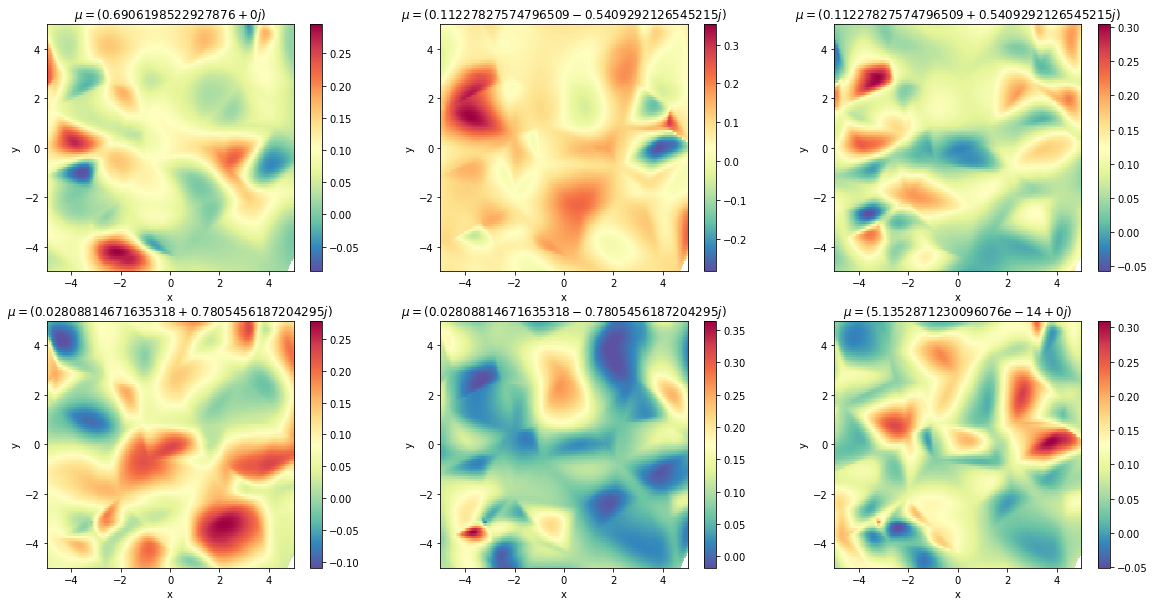

In [32]:
grid_x, grid_y = np.mgrid[-4:4:100j, -4:4:200j]
plt.figure(figsize=(20,10))
for i in range(1, 7):
    plt.subplot(2, 3, i)
    data = evec[i]
    # grid the data.
    title = r"$\mu = {0}$".format(eva[i])
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    z = np.absolute(data)
    z /= np.linalg.norm(z)
    zi = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    im = plt.imshow(zi, cmap=plt.cm.Spectral_r, extent=(-5, 5, -5, 5))
    plt.colorbar(im) 
    plt.savefig("result_lti1.png", format="png")
    